# Predicting Future Sales
https://www.kaggle.com/c/competitive-data-science-predict-future-sales/

## Step 1: Loading and Joining Data  

The dataset descriptions are provided by the competition here: https://www.kaggle.com/c/competitive-data-science-predict-future-sales/data  
### Datasets
**sales_train.csv**: the training set. Daily historical data from January 2013 to October 2015.  
**test.csv**: the test set. You need to forecast the sales for these shops and products for November 2015.  
**sample_submission.csv**: a sample submission file in the correct format.  
**items.csv**: supplemental information about the items/products.  
**item_categories.csv** : supplemental information about the items categories.  
**shops.csv**- supplemental information about the shops.  


### Data Dictionary
**ID**: an Id that represents a (Shop, Item) tuple within the test set  
**shop_id**: unique identifier of a shop  
**item_id**: unique identifier of a product  
**item_category_id**: unique identifier of item category  
**item_cnt_day**: number of products sold. You are predicting a monthly amount of this measure  
**item_price**: current price of an item  
**date**: date in format dd/mm/yyyy  
**date_block_num**: a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33  
**item_name**: name of item  
**shop_name**: name of shop  
**item_category_name**: name of item category  


To create a model that can best predict sales, we need to join the other dimensions of the 'items' and 'shops' datasets, then identify which features to keep in our final model.  
Alternatively, we could use a model that includes feature selection (e.g. Neural Network)

In [179]:
# Load necessary packages
import pandas as pd
import numpy as np
from fastai.collab import series2cat 

In [180]:
#Load Data
sales_train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
sales_test = pd.read_csv('test.csv',usecols = ['item_id','shop_id'])


#ensure shop_id and item_id is loaded as a category not integer
series2cat(sales_train, 'shop_id','item_id')
series2cat(sales_test, 'shop_id','item_id')

In [181]:
#Display datasets
for df in [sales_train, items, shops, sales_test]:
    display(df.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id,item_id
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [182]:
#merge data
sales_train = pd.merge(sales_train, items, on = 'item_id', how = 'left')
sales_train = pd.merge(sales_train, shops, on = 'shop_id', how = 'left')
display(sales_train.head())

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name
0,02.01.2013,0,59,22154,999.00,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,"Москва ТРК ""Атриум"""


Another important part of this step is to preview what the test output appears as well as the sample submission to make sure we create the most relevant model.

In [183]:
sample_submission = pd.read_csv('sample_submission.csv') 
display(sample_submission.head())

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Display how many shop id and item id are not in our dataset.

In [184]:
display(np.isin(sales_test['shop_id'].unique(),sales_train['shop_id'].unique(),invert = True).sum()/len(sales_test['shop_id'].unique())) #Counts how many shops are not in our training set
display(np.isin(sales_test['item_id'].unique(),sales_train['item_id'].unique(),invert = True).sum()/len(sales_test['item_id'].unique())) #Counts how many items are not in our training set
display((~sales_test['item_id'].isin(items['item_id'])).sum()) #How many items are not in the items dataset

0.0

0.0711764705882353

0

Good news! All shops are within our training set. No new shops need to be predicted. While 7.1% of items are not in our training dataset, they are in the items dataset. Meaning we do not have to worry about missing values.

Split test set into two categories:
1. `exist_combinations`: where the combination of shop_id and item_id has appeared at least once in the training set.
2. `unique_combinations`: where the combination of shop_id and item_id has never appeared.

In [185]:
train_combinations['test'] = False

all_combinations = pd.concat([train_combinations,sales_test],ignore_index = True)

all_combinations['test'] = all_combinations['test'].fillna(True)
exist_mask = all_combinations.duplicated(subset = ['shop_id','item_id'], keep = False)

exist_combinations = all_combinations[exist_mask & all_combinations['test']]
unique_combinations = all_combinations[~exist_mask & all_combinations['test']]

In the test set, each is a unique combination of 'shop_id' and 'item_id' however this combination may not be useful (e.g. a bakery is unlikely to sell paracetamol), so we should aim to create a model that can handle this. 

## Model 1: Collab filtering approach
Most basic approach would be to ignore all information aside from shop id, item id and to create a collaborative filtering.  
**Pros**: Non parametric model, simple to set up  
**Cons**: Doesn't take into account time data. Cold start problem (not good at predicting new items / shops. Not great at predicting continuous values.

### Data Transformation

In [314]:
from fastai.collab import * 

sum_items_by_shop_by_months = sales_train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum() #sum by items, shops by date_blocks
average_monthly_sales = sum_items_by_shop_by_months.reset_index().groupby(['shop_id','item_id'])['item_cnt_day'].mean()
average_monthly_sales = average_monthly_sales.reset_index()

#create index and training set where the last month (33)
average_monthly_sales_train = sum_items_by_shop_by_months.loc[0:32].reset_index().groupby(['shop_id','item_id'])['item_cnt_day'].mean().reset_index()
average_monthly_sales_verify = sum_items_by_shop_by_months.loc[33].reset_index()

In [315]:
def check_test_set(train_df, test_df, ind_vars = ['shop_id','item_id'], verbose = True):
    for df in train_df, test_df:
        for var in ind_vars:
            series2cat(df,var)
            
    exist_combn = train_df[~train_df.duplicated(subset = ind_vars)][ind_vars]
    test_combn = test_df[~test_df.duplicated(subset = ind_vars)][ind_vars]
    if test_combn.shape[0] != test_df.shape[0]:
        print('Test data has duplicate independent variables')
    
    concat_func = lambda x: ' '.join([str(i) for i in x])
    exist_combn = exist_combn.apply(concat_func,axis = 1)
    test_combn =  test_combn.apply(concat_func,axis = 1)
    test_df['existing combination'] = test_combn.isin(exist_combn)
    if verbose:
        print(test_df['existing combination'].value_counts(normalize= True))
    for var in ind_vars:
        new_col = 'new {}'.format(var)
        test_df[new_col] = ~test_df[var].isin(train_df[var])
        if verbose:
            print(test_df[new_col].value_counts(normalize = True))
        
    return test_df

average_monthly_sales_verify = check_test_set(train_df = average_monthly_sales_train,
                                              test_df = average_monthly_sales_verify)
    
sales_test = check_test_set(train_df = average_monthly_sales,
              test_df = sales_test)

True     0.77419
False    0.22581
Name: existing combination, dtype: float64
False    0.991818
True     0.008182
Name: new shop_id, dtype: float64
False    0.904507
True     0.095493
Name: new item_id, dtype: float64
True     0.520093
False    0.479907
Name: existing combination, dtype: float64
False    1.0
Name: new shop_id, dtype: float64
False    0.928824
True     0.071176
Name: new item_id, dtype: float64


There's triple the amount of unknown combinations in the test site, this is likely that there have been some combinations that have been added that should be 0.

In [316]:
def cartesian_df(series1,series2):
    df1 = pd.DataFrame({series1.name:series1.unique(),
             'cartesian':1})
    df2 = pd.DataFrame({series2.name:series2.unique(),
             'cartesian':1})
    
    df = pd.merge(df1,df2, on = 'cartesian')
    df = df.drop('cartesian',axis = 1)
    return df

#create cartesian df
cart_df = cartesian_df(average_monthly_sales_train['shop_id'],average_monthly_sales_train['item_id'])

#fill cartesian df when combiniation is known, else fill with 0. Add random column to help order
cart_df = pd.merge(cart_df,average_monthly_sales[['shop_id','item_id','item_cnt_day']], on = ['shop_id','item_id'], how = 'left')
cart_df['item_cnt_day'] = cart_df['item_cnt_day'].fillna(0)
cart_df['rand'] = np.random.rand(cart_df.shape[0])
null_combinations = cart_df[cart_df['item_cnt_day'] == 0].sort_values('rand')

#randomly select null combinations
extra_combinations_needed = (~average_monthly_sales_verify['existing combination']).sum() * 2
null_combinations = null_combinations.iloc[0:extra_combinations_needed,0:3]

#add extra null combinations
average_monthly_sales_verify = pd.concat([average_monthly_sales_verify,null_combinations], ignore_index = True)
average_monthly_sales_verify = average_monthly_sales_verify.fillna(False)

#remove new_shop_id No values in test set.
average_monthly_sales_verify = average_monthly_sales_verify[~average_monthly_sales_verify['new shop_id']]

In [340]:
var_cols = ['existing combination', 'new shop_id','new item_id']
for col in var_cols:
    display(average_monthly_sales_verify[col].value_counts(normalize = True))
    display(sales_test[col].value_counts(normalize = True))
    
var_cols.remove('new shop_id')

True     0.536352
False    0.463648
Name: existing combination, dtype: float64

True     0.520093
False    0.479907
Name: existing combination, dtype: float64

False    1.0
Name: new shop_id, dtype: float64

False    1.0
Name: new shop_id, dtype: float64

False    0.934283
True     0.065717
Name: new item_id, dtype: float64

False    0.928824
True     0.071176
Name: new item_id, dtype: float64

Test and validation set look much more similar now.

## Train

In [469]:
binary_monthly_sales_verify = average_monthly_sales_verify.copy()
binary_monthly_sales_verify['item_cnt_day'] = np.minimum(binary_monthly_sales_verify['item_cnt_day'],1)

binary_monthly_sales_train = average_monthly_sales_train.copy()
binary_monthly_sales_train['item_cnt_day'] = np.minimum(binary_monthly_sales_train['item_cnt_day'],1)

In [471]:
def create_databunch(train_df:pd.DataFrame, test_df:pd.DataFrame, seed:int):
    data_test = TabularList.from_df(test_df)
    data = CollabDataBunch.from_df(train_df, seed = seed)
    data.add_test(data_test)
    
    return data

data = create_databunch(average_monthly_sales_train,average_monthly_sales_verify, seed = 42)

if binary:
    data = create_databunch(binary_monthly_sales_train, binary_monthly_sales_verify, seed = 42)

Box plot shows dataset has extreme outliers. Therefore we will use quantiles to base our range rather than min and max values

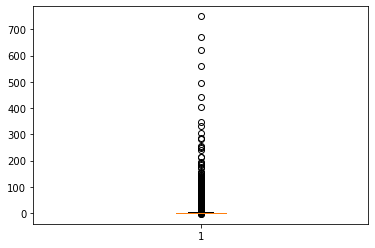

In [512]:
plt.boxplot(average_monthly_sales_train['item_cnt_day'])
sales_range = (0.,float(np.quantile(average_monthly_sales_train['item_cnt_day'],q = .99)))
if binary:
    sales_range = [0.,1.]

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


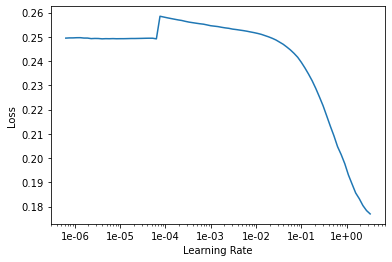

In [515]:
learn = collab_learner(data, n_factors=100, y_range=sales_range)
learn.lr_find()
learn.recorder.plot()

In [498]:
import torch
torch.cuda.set_device(0)

Based on this, we select a max learning rate at a point where the graph is steepest.

In [520]:
learn.fit_one_cycle(5, max_lr = .5, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.028430,0.023301,01:48
1,0.041043,0.035918,01:47
2,0.032368,0.018103,01:47
3,0.007306,0.004969,01:47
4,0.001060,0.001763,01:50


### Predict Values

In [521]:
def verify_data(verify_df:pd.DataFrame, model):  
    preds = model.get_preds(ds_type=DatasetType.Test)
    verify_df['pred'] = preds[0]
    verify_df['residual'] = verify_df['pred'] - verify_df['item_cnt_day']
    verify_df['residual_abs'] = abs(verify_df['residual'])
    return verify_df

binary_monthly_sales_verify = verify_data(binary_monthly_sales_verify, learn)

In [478]:
print(average_monthly_sales_verify.groupby(var_cols)['residual_abs'].mean())

existing combination  new item_id
False                 False          1.860966
                      True           3.037559
True                  False          1.562167
Name: residual_abs, dtype: float64


In [611]:
y_pred

,pred,pred
0,0.998661,0.001339
1,0.998274,0.001726
2,0.998309,0.001691
3,0.960171,0.039829
4,0.998939,0.001061
...,...,...
45766,0.924569,0.075431
45767,0.984966,0.015034
45768,0.997395,0.002605
45769,0.996535,0.003465


In [621]:
y_test = np.maximum(0,binary_monthly_sales_verify['item_cnt_day']).astype('int')

y_pred = pd.concat([binary_monthly_sales_verify['pred'],1-binary_monthly_sales_verify['pred']], axis = 1)

y_pred.columns = [1,0]

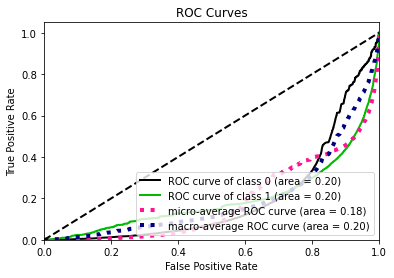

In [622]:
import scikitplot as skplt

skplt.metrics.plot_roc(y_test.values,y_pred.values)
plt.show()

In [616]:
y_test

,1,0
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
45766,0,1
45767,0,1
45768,0,1
45769,0,1


In [588]:
binary_monthly_sales_verify[['item_cnt_day']]

,item_cnt_day
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
45766,0.0
45767,0.0
45768,0.0
45769,0.0


In [582]:
np.maximum(0,binary_monthly_sales_verify['item_cnt_day'])
binary_monthly_sales_verify['pred']

0        0.998661
1        0.998274
2        0.998309
3        0.960171
4        0.998939
           ...   
45766    0.924569
45767    0.984966
45768    0.997395
45769    0.996535
45770    0.994919
Name: pred, Length: 45513, dtype: float32

In [577]:
np.maximum(0,binary_monthly_sales_verify['item_cnt_day']).value_counts()
binary_monthly_sales_verify['pred'].round().value_counts()

1.0    45510
0.0        3
Name: pred, dtype: int64

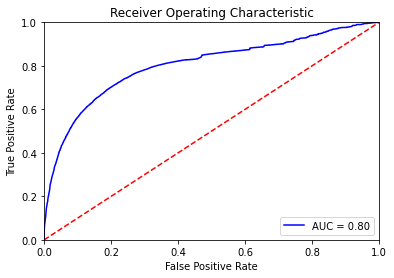

In [589]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(np.maximum(0,binary_monthly_sales_verify['item_cnt_day']), binary_monthly_sales_verify['pred'])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [593]:
roc_auc

0.8038991047228456

In [578]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    print(i)
    fpr[i], tpr[i], _ = roc_curve(np.maximum(binary_monthly_sales_verify['item_cnt_day'],0), binary_monthly_sales_verify['pred'])
    roc_auc[i] = auc(fpr[i], tpr[i])

print (roc_auc_score(test, pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.show()

0
1


NameError: name 'roc_auc_score' is not defined

0        0.998661
1        0.998274
2        0.998309
3        0.960171
4        0.998939
           ...   
45766    0.924569
45767    0.984966
45768    0.997395
45769    0.996535
45770    0.994919
Name: pred, Length: 45513, dtype: float32

In [542]:
binary_monthly_sales_verify['item_cnt_day']

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
45766    0.0
45767    0.0
45768    0.0
45769    0.0
45770    0.0
Name: item_cnt_day, Length: 45513, dtype: float64

In [531]:
len(binary_monthly_sales_verify['pred'].values)

45513

In [526]:
binary_monthly_sales_verify['item_cnt_day'].values

array([1., 1., 1., 1., ..., 0., 0., 0., 0.])

In [486]:
round(binary_monthly_sales_verify['pred']).value_counts(normalize = True)

1.0    0.999692
0.0    0.000308
Name: pred, dtype: float64

Similar performance whether existing combination is known or not. The biggest drop in accuracy is when there's a new item

In [398]:
print(average_monthly_sales_verify.groupby('item_cnt_day')['residual_abs'].mean()[np.arange(sales_range[0],sales_range[1])])

item_cnt_day
0.0    1.974057
1.0    1.018989
2.0    1.068859
3.0    1.395096
4.0    1.691499
5.0    2.164824
6.0    2.596162
7.0    2.951889
8.0    3.885411
9.0    4.664387
Name: residual_abs, dtype: float64


Text(0.5, 0, 'Actual Values')

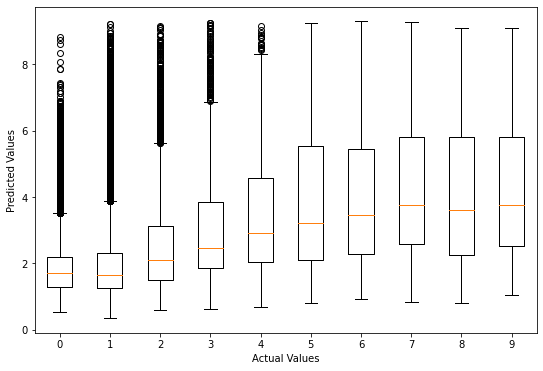

In [451]:
sales_vals = np.arange(sales_range[0],sales_range[1]).astype(int)
box_plot_data = [average_monthly_sales_verify[average_monthly_sales_verify['item_cnt_day'] == val]['collab_filtering_v2'] for val in sales_vals]

fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
bp = ax.boxplot(box_plot_data)

ax.set_xticklabels(sales_vals)
plt.ylabel('Predicted Values')
plt.xlabel('Actual Values')



Not as accurate when selecting 0. Although it also isn't great at selecting high numbers, these numbers are more rare.

Outcome: Model could be improved by using an additional two models.
1. A classification model that aims to pair a new item with its most likely combination
2. A classification model that just focuses on whether an item is likely to sell or not.

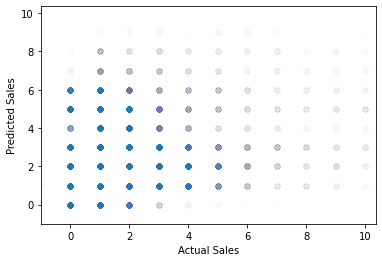

In [436]:
plt.scatter(average_monthly_sales_verify['item_cnt_day'],np.floor(average_monthly_sales_verify['collab_filtering_v2']), alpha = 0.0023)
plt.ylim(np.add(sales_range,(-1,1)))
plt.xlim(np.add(sales_range,(-1,1)))
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')

plt.show()

In [444]:
box_plot_data

[510      2.008727
 534      1.996825
 1477     2.054665
 3382     1.157970
 3714     6.462871
            ...   
 45766    2.114603
 45767    6.130525
 45768    1.617303
 45769    1.073704
 45770    1.913949
 Name: collab_filtering_v2, Length: 14288, dtype: float32,
 0        2.684104
 2        1.240026
 3        1.391193
 4        1.693428
 5        2.020735
            ...   
 31524    0.927184
 31525    1.052572
 31528    2.547256
 31529    1.787635
 31530    5.084676
 Name: collab_filtering_v2, Length: 21136, dtype: float32,
 11       1.688356
 16       3.610930
 27       2.125502
 34       2.685547
 35       2.308930
            ...   
 31495    1.357528
 31508    1.242545
 31517    1.106330
 31522    2.139680
 31527    3.898035
 Name: collab_filtering_v2, Length: 5040, dtype: float32,
 1        2.479402
 31       4.284751
 37       3.147288
 50       1.801473
 82       4.379488
            ...   
 31394    3.543597
 31397    2.426035
 31404    3.896730
 31407    1.612335
 31454 

In [356]:
def pred_data(df: pd.DataFrame, model, new_col:str = 'pred'):
    data = TabularList.from_df(df)
    pred = learn.get_preds(ds_type = data)
    #df[new_col] = pred[0]
    return pred[0]

In [146]:
def comp_export(sales_test:pd.DataFrame,predict_col:str, export_name:str):
    sales_test = pred_data(sales_test)
    sales_test.index.name = 'ID'
    sales_test['item_cnt_month'].to_csv(export_name)

comp_export(sales_test,'collab_filtering_v3','first_test.csv')

In [199]:
sales_test['item_cnt_day'].shape

(214200,)